# Future predictions

In this notebook we train and calibrate our best-performing model using all available data to predict whether or not a given player will play in the NBA _at any point_ during the 2024-2025 season.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from HelperFunctions import *

## Loading the full dataset

In [31]:
#load/scale data
df        = pd.read_csv("full_data.csv")
df_scaled = ImputeAndScale(df.copy())
features  = df_scaled.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])

In [32]:
#make 2023-2024 season the test set
df_train = df_scaled.loc[df_scaled.SEASON_START < 2017]
df_test  = df_scaled.loc[df_scaled.SEASON_START >= 2017]

In [33]:
#split training data into a train set and a calibration set
df_tt, df_cal = train_test_split(df_train, test_size=0.2, shuffle=True, 
                                 random_state=815, stratify=df_train.IN_LEAGUE_NEXT)

## Training the model

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

model = Pipeline([('smote', SMOTE(random_state=23)),
                  ('xgb', XGBClassifier(n_estimators=350, learning_rate=0.005, random_state=206))])

model.fit(df_tt[features], df_tt.IN_LEAGUE_NEXT)

model_cal = CalibratedClassifierCV(model, cv="prefit")
model_cal.fit(df_cal[features], df_cal.IN_LEAGUE_NEXT)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('smote',
                                                  SMOTE(random_state=23)),
                                                 ('xgb',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=None,
                                                                colsample_bytree=None,
                                                                device=None,
                                                                early_stopping_rounds=None,
                                                                enable_categorical=False,
                                                                eval_metric=None,
                                                                feature_types=None,
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.005,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=350,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=206, ...))]))

## Visualize training data

Make scatterplots with a choice of predictors on the x and y axes, and color the points based on `IN_LEAGUE_NEXT`.

In [35]:
def visualize_train(x, y, year):
    sns.scatterplot(data=df.loc[df.SEASON_START==year], x=x, y=y, hue="IN_LEAGUE_NEXT", palette=["lightcoral", "black"])
    plt.show()
    return None

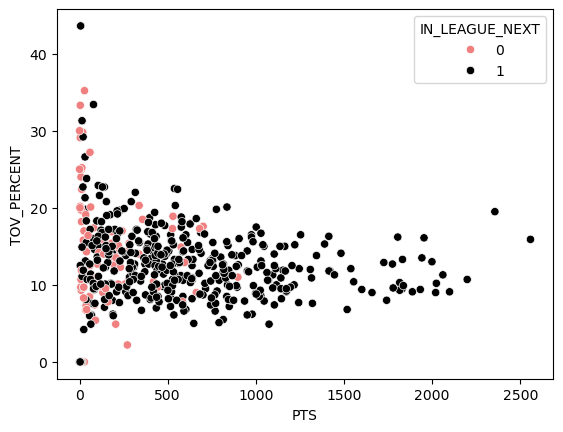

In [36]:
visualize_train("PTS", "TOV_PERCENT", 2016)

## Visualize model output

Plots arbitrary predictors on x axis vs predicted probability on y axis for unseen test data (2016-2022).

In [37]:
def visualize_test(x, y, year):
    colormap_name = "viridis_r"
    
    ax = sns.scatterplot(x=df.loc[df.SEASON_START==year][x], y=df.loc[df.SEASON_START==year][y], 
                         hue=model_cal.predict_proba(df_scaled.loc[df_scaled.SEASON_START==year][features])[:, 1],
                         palette=colormap_name,
                         style=df.loc[df.SEASON_START==year].IN_LEAGUE_NEXT,
                         markers=['X', '.'],
                         legend=False)
    
    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap_name)
    sm.set_array([])  # Set an empty array to avoid warnings

    # Add the colorbar to the plot
    plt.colorbar(sm, ax=ax)

    plt.show()
    return None

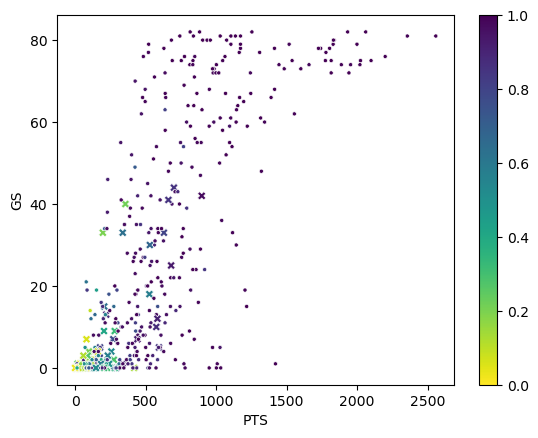

In [38]:
visualize_test("PTS", "GS", 2016)

In [39]:
def visualize_prob(x, y, year):
    colormap_name = "viridis_r"
    
    ax = sns.scatterplot(x=df.loc[df.SEASON_START==year][x],
                         y=model_cal.predict_proba(df_scaled.loc[df_scaled.SEASON_START==year][features])[:, 1],
                         hue=df.loc[df.SEASON_START==year].IN_LEAGUE_NEXT==model.predict(df_scaled.loc[df_scaled.SEASON_START==year][features]),
                         palette=['r', 'k'],
                         legend=False)
    
    # Create a colorbar
    #sm = plt.cm.ScalarMappable(cmap=colormap_name)
    #sm.set_array([])  # Set an empty array to avoid warnings

    # Add the colorbar to the plot
    #plt.colorbar(sm, ax=ax)

    plt.show()
    return None

In [40]:
df["TEAMS_AS_LIST"] = df.apply(lambda x: eval(x.TEAMS_LIST), axis=1)

In [52]:
df_exploded = df.explode("TEAMS_AS_LIST", ignore_index=True)

In [55]:
df_exploded.loc[(df_exploded.TEAMS_AS_LIST == "CHI") & (df_exploded.SEASON_START == 2023)]

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,...,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,IN_LEAGUE_NEXT,TEAMS_AS_LIST
11864,DeMar DeRozan,201942,2023,['CHI'],34.0,15.0,SF,79.0,79.0,2989.0,...,0,0,0,0,0,0,0,0,0,CHI
12959,Nikola Vucevic,202696,2023,['CHI'],33.0,13.0,C,76.0,74.0,2610.0,...,0,0,0,0,0,0,0,0,0,CHI
13347,Andre Drummond,203083,2023,['CHI'],30.0,12.0,C,79.0,10.0,1351.0,...,0,0,0,0,0,0,0,0,0,CHI
14310,Zach LaVine,203897,2023,['CHI'],29.0,10.0,SG,25.0,23.0,872.0,...,0,0,0,0,0,0,0,0,0,CHI
15623,Alex Caruso,1627936,2023,['CHI'],30.0,7.0,SG,71.0,57.0,2040.0,...,0,0,0,0,0,0,0,0,0,CHI
16023,Torrey Craig,1628470,2023,['CHI'],33.0,7.0,SF,53.0,14.0,1049.0,...,0,0,0,0,0,0,0,0,0,CHI
16148,Jevon Carter,1628975,2023,['CHI'],28.0,6.0,PG,72.0,0.0,1004.0,...,0,0,0,0,0,0,0,0,0,CHI
16668,Coby White,1629632,2023,['CHI'],24.0,5.0,PG,79.0,78.0,2881.0,...,0,0,0,0,0,0,0,0,0,CHI
16968,Javonte Green,1629750,2023,['CHI'],30.0,5.0,SF,9.0,5.0,230.0,...,0,0,0,0,0,0,0,0,0,CHI
17033,Patrick Williams,1630172,2023,['CHI'],22.0,4.0,PF,43.0,30.0,1174.0,...,0,0,0,0,0,0,0,0,0,CHI
